# Import libraries

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2
from urllib import request
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
# Set computation device (GPU or CPU)
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA")
else:
    device = torch.device('cpu')
    print("CPU")

CUDA


# Load dataset

In [3]:
# Removing unnecessary columns for the analysis
df = pd.read_csv('/kaggle/input/fakeddit-dataset/multimodal_only_samples/multimodal_train.tsv', sep='\t')
df.drop(['2_way_label', '3_way_label', 'title'], axis=1, inplace=True)

Remove the columns for "2-way", "3-way" and "title" classification 

In [4]:
df.head()

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,upvote_ratio,6_way_label
0,Alexithymia,my walgreens offbrand mucinex was engraved wit...,1.551641e+09,i.imgur.com,True,awxhir,https://external-preview.redd.it/WylDbZrnbvZdB...,NaN,2.0,12,mildlyinteresting,0.84,0
1,VIDCAs17,this concerned sink with a tiny hat,1.534727e+09,i.redd.it,True,98pbid,https://preview.redd.it/wsfx0gp0f5h11.jpg?widt...,NaN,2.0,119,pareidolia,0.99,2
2,prometheus1123,hackers leak emails from uae ambassador to us,1.496511e+09,aljazeera.com,True,6f2cy5,https://external-preview.redd.it/6fNhdbc6K1vFA...,NaN,1.0,44,neutralnews,0.92,0
3,NaN,puppy taking in the view,1.471341e+09,i.imgur.com,True,4xypkv,https://external-preview.redd.it/HLtVNhTR6wtYt...,NaN,26.0,250,photoshopbattles,0.95,0
4,3rikR3ith,i found a face in my sheet music too,1.525318e+09,i.redd.it,True,8gnet9,https://preview.redd.it/ri7ut2wn8kv01.jpg?widt...,NaN,2.0,13,pareidolia,0.84,2


In [5]:
df.shape

(564000, 13)

In [6]:
# Reduce dataset size for quick experimentation
df, _ = train_test_split(
    df,
    test_size=0.97,
    shuffle=True,
    stratify=df["6_way_label"]
)

Use train_test_split() to reduce the original dataset of over 564,000 samples, selecting only 3% for training due to limited computational resources. The stratify parameter ensures the reduced dataset maintains the original class distribution proportions of the Fakeddit dataset.

In [7]:
df.shape

(16920, 13)

In [8]:
df.reset_index(drop=True, inplace=True)

In [9]:
# Check missing values
print("clean_title:", df["clean_title"].isnull().sum())
print("has_image:", df["hasImage"].isnull().sum())
print("id:", df["id"].isnull().sum())

# Check how many rows with the column "hasImage" is false
print("\n", df["hasImage"].value_counts())

clean_title: 0
has_image: 0
id: 0

 hasImage
True    16920
Name: count, dtype: int64


Plot the 6- Way Class Distribution of dataset:

0: TRUE

1: SATIRE

2: FALSE CONNECTION

3: IMPOSTER CONTENT

4: MANIPULATED CONTENT

5: MISLEADING CONTENT

<Axes: title={'center': '6_way_label'}, ylabel='Frequency'>

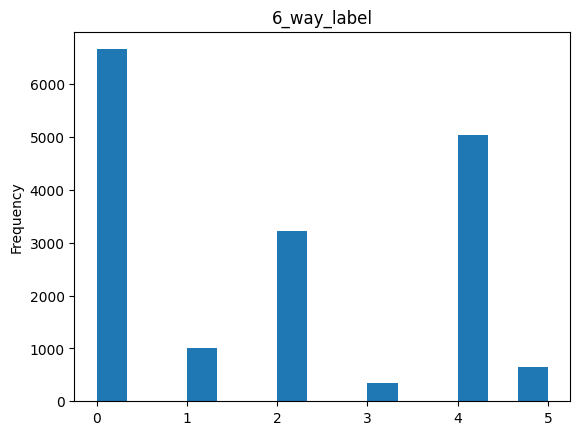

In [10]:
# Plot class distribution
df["6_way_label"].plot(kind="hist", bins=15, title="6_way_label")

# Handle missing values

In [11]:
# Replace NaN values with empty strings
df = df.replace(np.nan, '', regex=True)
df.fillna('', inplace=True)

# Create the directory to store images if it doesn't exist
image_directory = "/kaggle/working/images"
if not os.path.exists(image_directory):
    os.makedirs(image_directory)

# Function to download a single image
def download_image(row):
    image_url = row["image_url"]
    image_path = os.path.join(image_directory, f"{row['id']}.jpg")

    try:
        # Download the image and save it to the file path
        with open(image_path, 'wb') as f:
            f.write(request.urlopen(image_url).read())
        return True  # Success
    except Exception:
        return False  # Failed to download

# Function to process a single row in the dataframe
def process_row(index, row):
    if row["hasImage"] and row["image_url"] not in ["", "nan"]:
        success = download_image(row)
        if not success:
            # Remove the row from the dataframe if download fails
            return index
    return None

# Use ThreadPoolExecutor to download images concurrently
failed_indices = []
with ThreadPoolExecutor(max_workers=10) as executor:  # You can adjust the number of threads with max_workers
    futures = {executor.submit(process_row, index, row): index for index, row in df.iterrows()}
    
    for future in as_completed(futures):
        index = futures[future]
        try:
            failed_index = future.result()
            if failed_index is not None:
                failed_indices.append(failed_index)
        except Exception as exc:
            print(f"An error occurred for row {index}: {exc}")

# Remove failed rows from the dataframe
df.drop(index=failed_indices, inplace=True)
df.reset_index(drop=True, inplace=True)

print("Downloaded all images.")

Downloaded all images.


(173, 320, 3)


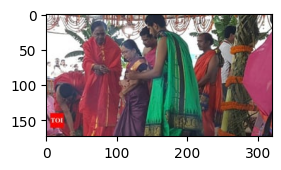

(240, 320, 3)


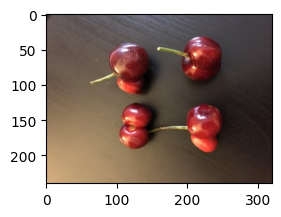

(180, 320, 3)


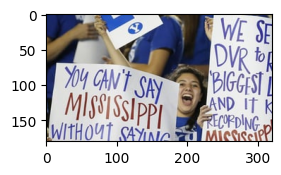

(320, 320, 3)


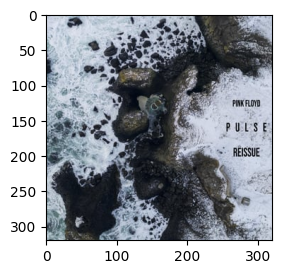

(180, 320, 3)


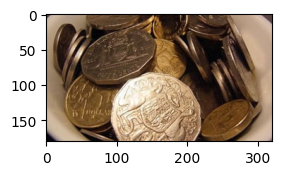

In [12]:
# Plotting images to test download
for i in range(5):
    path = "/kaggle/working/images/" + df["id"][i] + ".jpg"

    im= np.array(Image.open(path))

    print(im.shape)
    ax= plt.subplot(121)
    ax.imshow(im)

    plt.show()

# # Resize images to uniform size
The images in the dataset vary in size, which is incompatible with CNN input requirements.
Therefore, all images are resized to a consistent shape of (256, 256, 3) to ensure uniformity during training.

In [13]:
# # Load the RGBA image
# image_path = "/kaggle/working/images/" + df["id"][0] + ".jpg"
# image = Image.open(image_path).convert("RGB")

# # Split the image into individual channels
# r, g, b = image.split()

# # Plot each channel separately
# plt.figure(figsize=(10, 5))

# plt.subplot(1, 4, 1)
# plt.imshow(r)
# plt.title('Red Channel')

# plt.subplot(1, 4, 2)
# plt.imshow(g)
# plt.title('Green Channel')

# plt.subplot(1, 4, 3)
# plt.imshow(b)
# plt.title('Blue Channel')

# #plt.subplot(1, 4, 4)
# #plt.imshow(a)
# #plt.title('Alpha Channel')

# plt.tight_layout()
# plt.show()

In [14]:
def validate_images(directory):
    corrupted_files = []

    # Walk through directory and sub-directories
    for index, row in df.iterrows():
      image_path = "/kaggle/working/images/" + row["id"] + ".jpg"
      try:
          with Image.open(image_path) as img:
              img.verify()
      except Exception as e:
          corrupted_files.append(image_path)
          # print(f"Error with {image_path}: {e}")
          df.drop(index=index, axis=0, inplace=True)

    return corrupted_files


# Example usage:
directory = "/kaggle/working/images/"
corrupted_images = validate_images(directory)
if corrupted_images:
    print(f"Found {len(corrupted_images)} corrupted images.")
else:
    print("All images are valid!")
df.reset_index(drop=True, inplace=True)

Found 54 corrupted images.


In [15]:
# Resize all images to (256, 256, 3)
new_size = (256, 256)

for index, row in df.iterrows():
    image_path = "/kaggle/working/images/" + row["id"] + ".jpg"
    image = Image.open(image_path).convert("RGB")
    
    resize_transform = v2.Resize(new_size)
    resized_image = resize_transform(image)
    resized_image.save(image_path)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [16]:
# # Plotting images to test resize
# for i in range(5):
#     path = "/kaggle/working/images/" + df["id"][i] + ".jpg"

#     im = np.array(Image.open(path))

#     print(im.shape)
#     ax = plt.subplot(121)
#     ax.imshow(im)

#     plt.show()

# CNN model and training pipeline for Fakeddit

Epoch 1/30 - Train loss: 1.7165, acc: 52.66% | Val loss: 1.1697, acc: 56.71%
Epoch 2/30 - Train loss: 1.1846, acc: 54.89% | Val loss: 1.1612, acc: 56.79%
Epoch 3/30 - Train loss: 1.1446, acc: 55.26% | Val loss: 1.1196, acc: 57.42%
Epoch 4/30 - Train loss: 1.0811, acc: 57.36% | Val loss: 1.1264, acc: 58.04%
Epoch 5/30 - Train loss: 0.9997, acc: 60.06% | Val loss: 1.1352, acc: 57.33%
Epoch 6/30 - Train loss: 0.8748, acc: 65.59% | Val loss: 1.1735, acc: 52.53%
Epoch 7/30 - Train loss: 0.7037, acc: 72.32% | Val loss: 1.3680, acc: 56.39%
Epoch 8/30 - Train loss: 0.4975, acc: 80.24% | Val loss: 1.4819, acc: 52.26%
Epoch 9/30 - Train loss: 0.3461, acc: 86.98% | Val loss: 1.8699, acc: 53.24%
Epoch 10/30 - Train loss: 0.2298, acc: 92.24% | Val loss: 2.0691, acc: 52.98%
Epoch 11/30 - Train loss: 0.1637, acc: 94.60% | Val loss: 2.4361, acc: 52.49%
Epoch 12/30 - Train loss: 0.1213, acc: 96.26% | Val loss: 2.5668, acc: 52.89%
Epoch 13/30 - Train loss: 0.1076, acc: 96.60% | Val loss: 2.6601, acc: 51

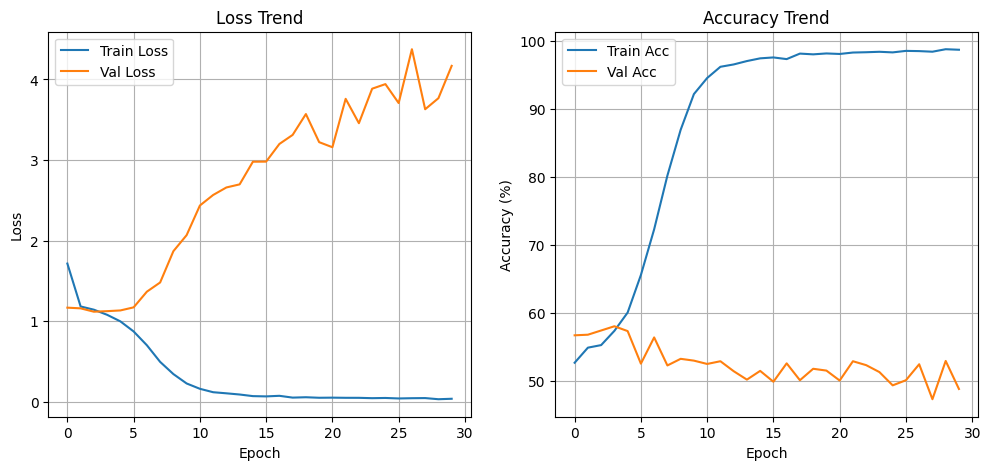

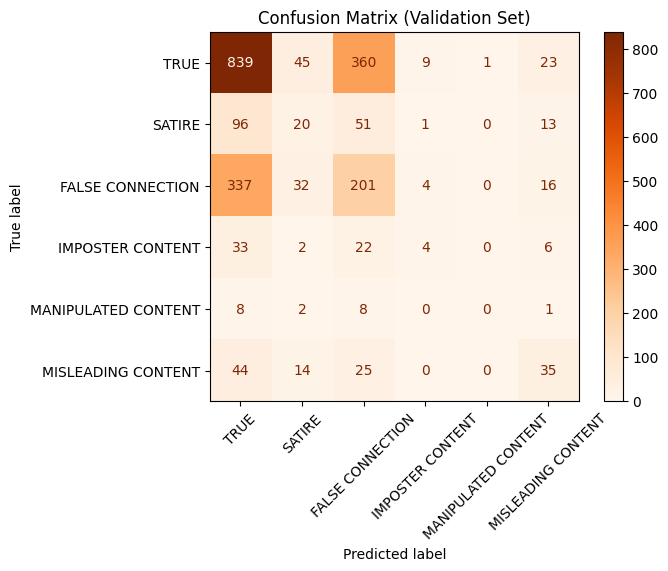

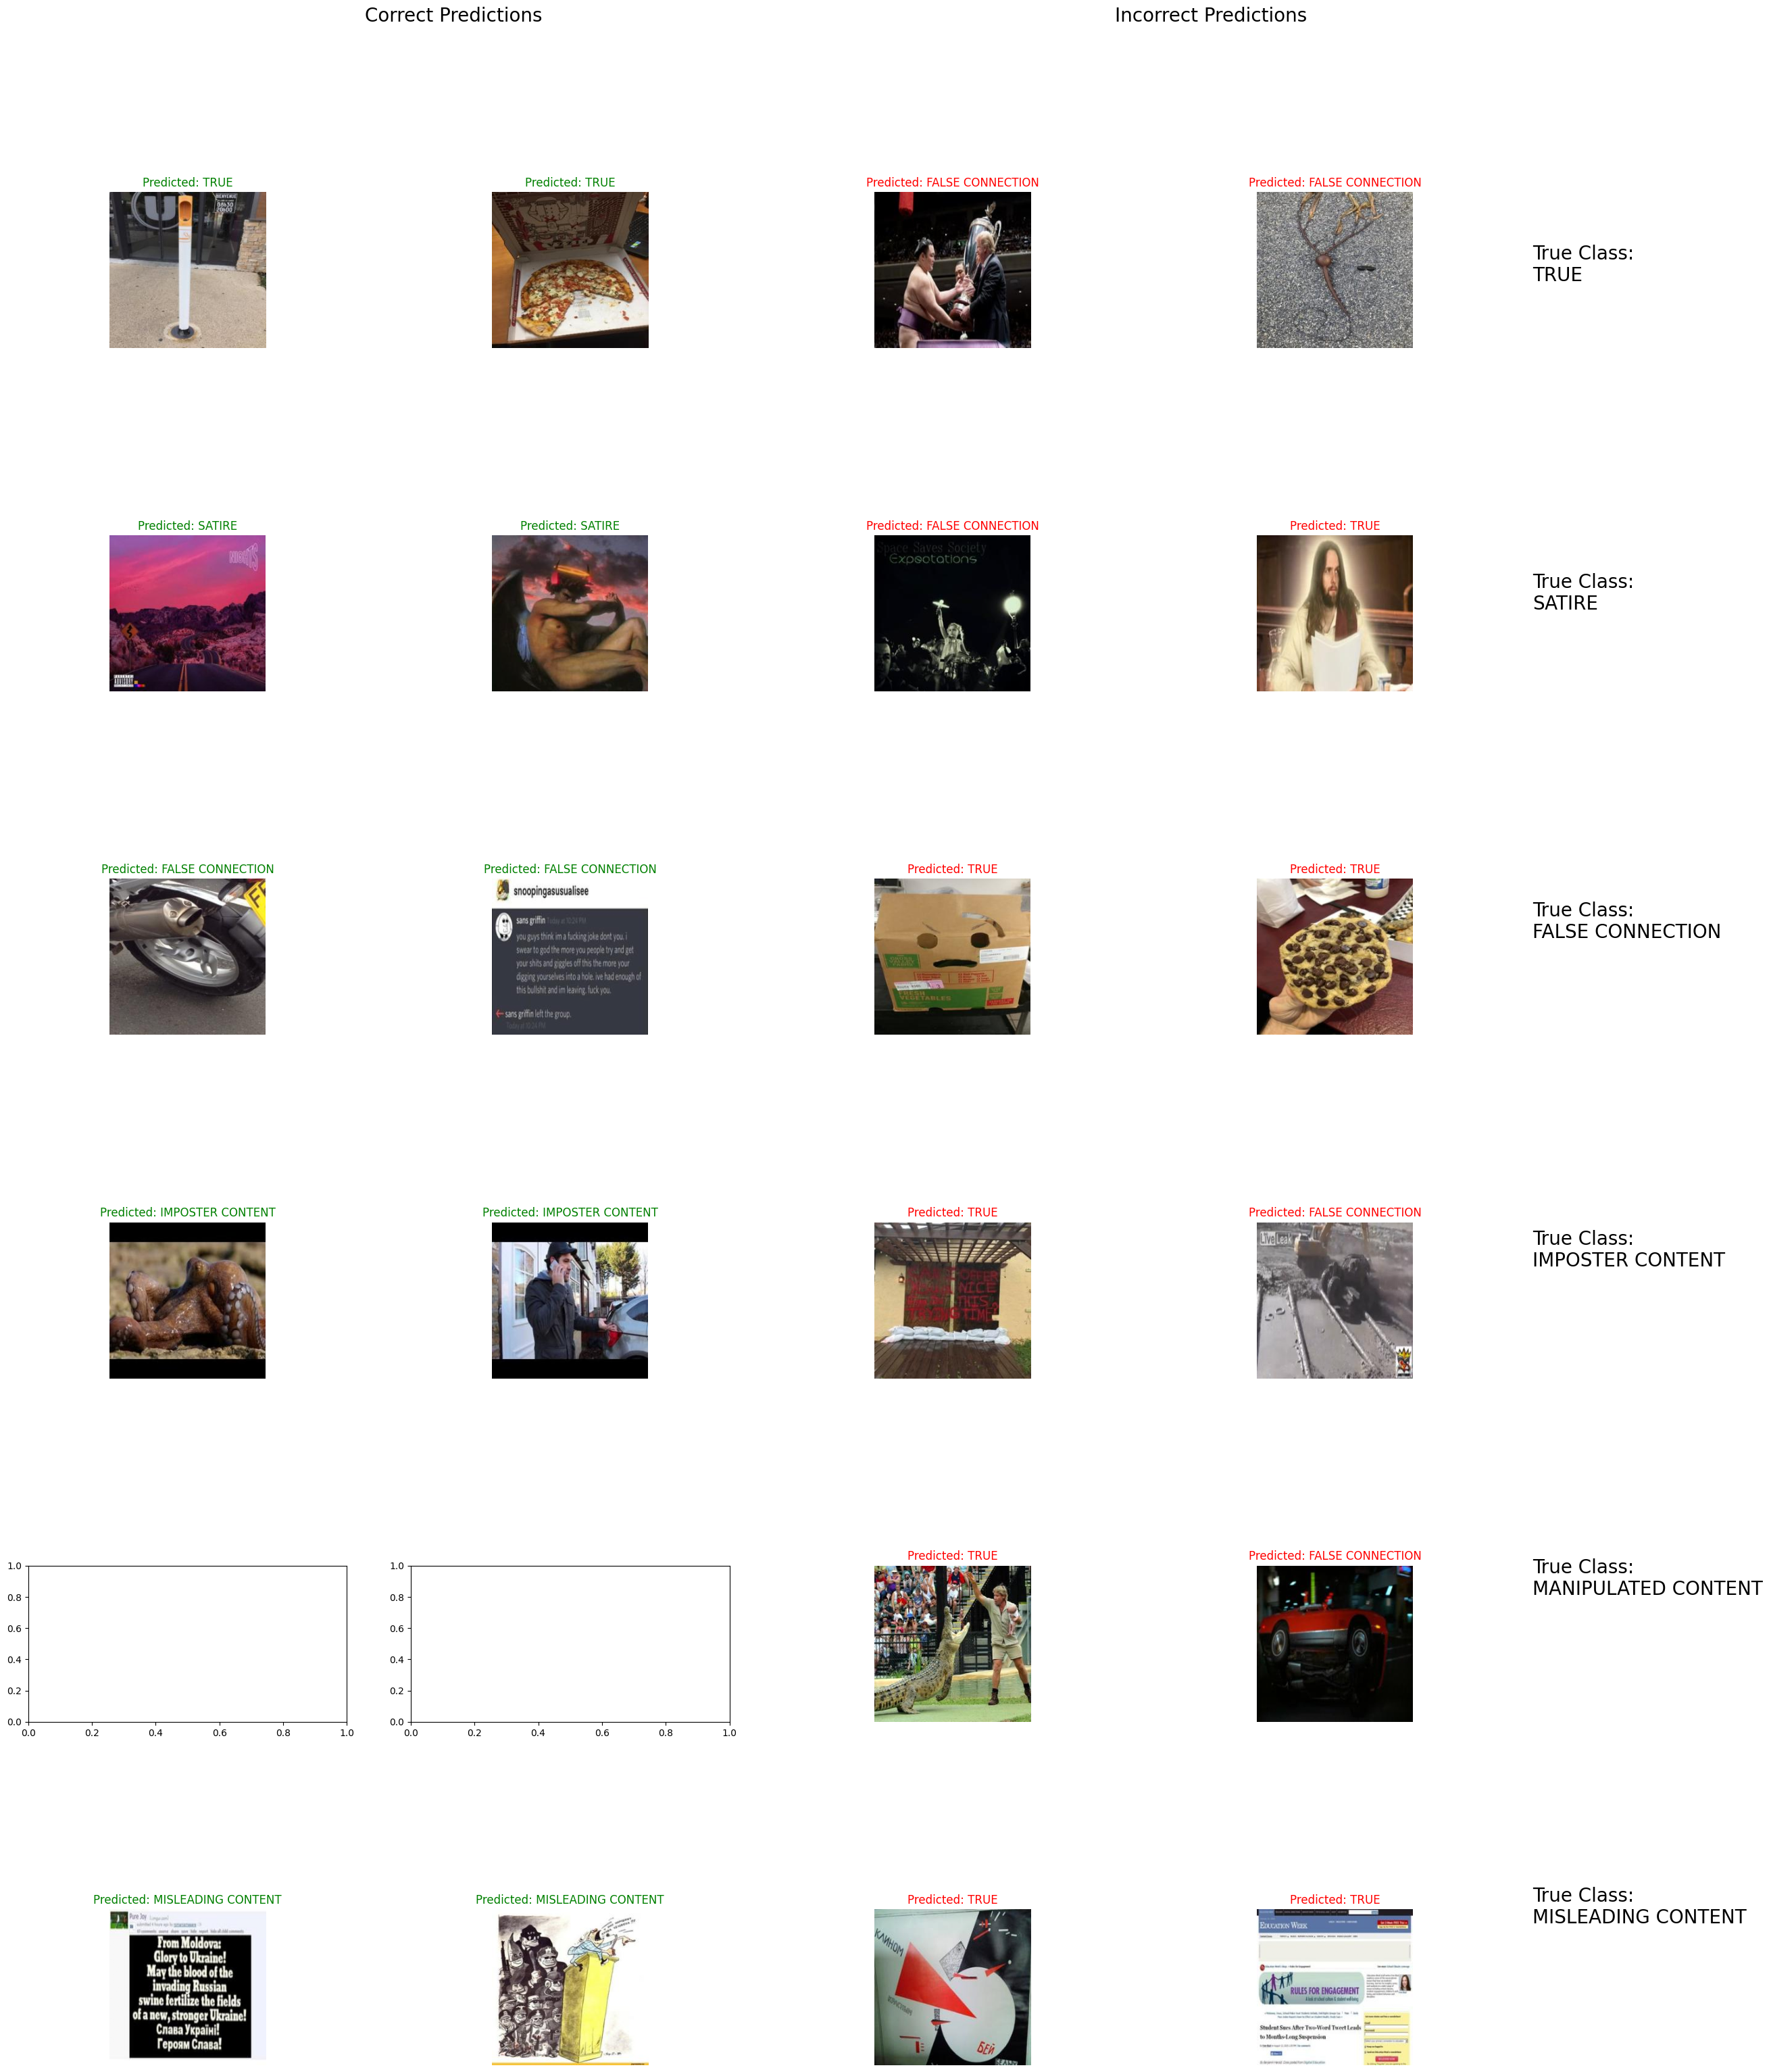

In [17]:
# 1. Label mapping
label_map = {
    0: "TRUE",
    1: "SATIRE",
    2: "FALSE CONNECTION",
    3: "IMPOSTER CONTENT",
    4: "MANIPULATED CONTENT",
    5: "MISLEADING CONTENT"
}
class_names = list(label_map.values())

# 2. Dataset class
# Prepare dataset with image transformation: resizing, tensor conversion, normalization
df = df.reset_index(drop=True)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Custom PyTorch Dataset to load Fakeddit image samples
class FakedditImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = f"/kaggle/working/images/{row['id']}.jpg"
        label = int(row['6_way_label'])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# 3. DataLoader setup
# Split dataset into train and validation sets (80/20 split)
full_dataset = FakedditImageDataset(df, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Loaders to batch data for training and validation
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 4. Simple CNN model
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 64 * 64, 256)
        self.fc2 = nn.Linear(256, 6)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(-1, 64 * 64 * 64)  # Flatten feature maps
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# 5. Model training setup (Initialize model, loss function, and optimizer)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cnn().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 6. Training and evaluation functions
# Train model for one epoch
def train_one_epoch(model, dataloader):
    model.train()
    total_loss, correct = 0, 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (output.argmax(1) == y).sum().item()
    acc = 100 * correct / len(dataloader.dataset)
    return total_loss / len(dataloader), acc
    
# Evaluate model on validation set
def eval_model(model, dataloader):
    model.eval()
    total_loss, correct = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)
            total_loss += loss.item()
            correct += (output.argmax(1) == y).sum().item()
            all_preds.extend(output.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    acc = 100 * correct / len(dataloader.dataset)
    return total_loss / len(dataloader), acc, all_preds, all_labels

# 7. Training loop
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
EPOCHS = 30
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc, preds, labels = eval_model(model, val_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train loss: {train_loss:.4f}, acc: {train_acc:.2f}% | Val loss: {val_loss:.4f}, acc: {val_acc:.2f}%")

# 8. Accuracy and loss visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Accuracy Trend')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

# 9. Confusion Matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Oranges')
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# 10. Visualize sample correct/incorrect predictions
# Show 2 correct and 2 incorrect predictions per class
def visualize_predictions(dataloader, model):
    model.eval()
    class_samples = {i: {'correct': [], 'incorrect': []} for i in range(6)}
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)
            for i in range(len(x)):
                true = y[i].item()
                pred = preds[i].item()
                category = 'correct' if true == pred else 'incorrect'
                if len(class_samples[true][category]) < 2:
                    class_samples[true][category].append((x[i].cpu(), true, pred))
            if all(len(samples['correct']) >= 2 and len(samples['incorrect']) >= 2 for samples in class_samples.values()):
                break

    fig, axs = plt.subplots(6, 4, figsize=(28, 36))
    plt.subplots_adjust(hspace=1.2)
    for class_idx in range(6):
        fig.text(0.92, 0.85 - (class_idx * 0.135), f"True Class:\n{class_names[class_idx]}", fontsize=20, va='center')
        for i, (img, true, pred) in enumerate(class_samples[class_idx]['correct']):
            ax = axs[class_idx, i]
            img_np = np.transpose(img.numpy(), (1, 2, 0))
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
            ax.imshow(img_np)
            ax.set_title(f"Predicted: {class_names[pred]}", color='green')
            ax.axis('off')
        for i, (img, true, pred) in enumerate(class_samples[class_idx]['incorrect']):
            ax = axs[class_idx, i+2]
            img_np = np.transpose(img.numpy(), (1, 2, 0))
            img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
            ax.imshow(img_np)
            ax.set_title(f"Predicted: {class_names[pred]}", color='red')
            ax.axis('off')
    fig.text(0.35, 0.95, 'Correct Predictions', fontsize=20, ha='center')
    fig.text(0.75, 0.95, 'Incorrect Predictions', fontsize=20, ha='center')
    plt.show()

# Run visualization
visualize_predictions(val_loader, model)
